## **Лабораторная работа №2.**
Быстрое преобразование Фурье. Вычисление дискретной свертки
---
3 Вариант Пересада Никита Сергеевич


In [5]:
import sympy as sp
import numpy as np
from matplotlib import pyplot as plt
from tabulate import tabulate
from IPython.display import display

**Задание №1.** Реализовать на `С` или `С++` алгоритмы непосредственного вычисления ДПФ и ОДПФ по формулам (1) и (2) для комплексного дискретного сигнала с двойной точностью (double). Входные данные загружать из бинарного файла, сгенерированного в `Python`

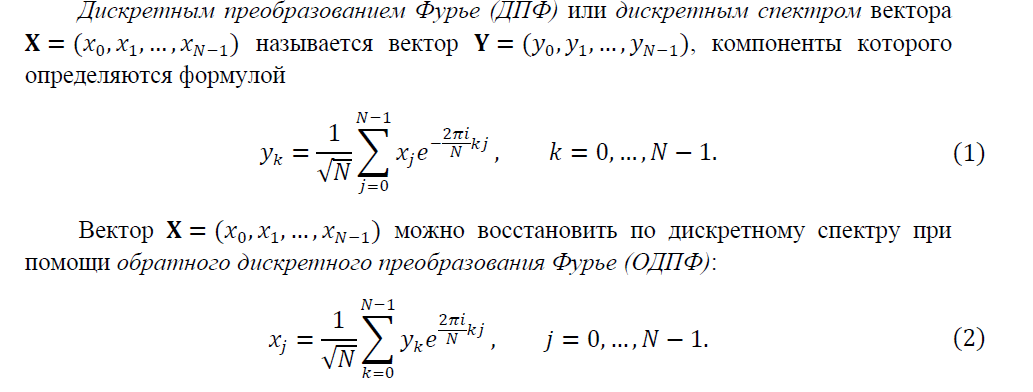

In [9]:
# Создаем комплексный сигнал
N = 1024  # Длина сигнала
signal = np.random.rand(N) + 1j * np.random.rand(N)

# Запись в бинарный файл
with open("input.bin", "wb") as f:
    f.write(np.int32(N))  # Записываем размер сигнала как int32
    f.write(signal.astype(np.complex128).tobytes())  # Записываем сигнал как complex128

In [ ]:
#include <iostream>
#include <vector>
#include <complex>
#include <fstream>
#include <cmath>

using namespace std;

// Функция для вычисления преобразования Фурье
vector<complex<double>> computeTransform(const vector<complex<double>>& inputSignal) {
    int signalLength = inputSignal.size();
    vector<complex<double>> transformedSignal(signalLength);

    for (int freqBin = 0; freqBin < signalLength; ++freqBin) {
        transformedSignal[freqBin] = 0.0;
        for (int timePos = 0; timePos < signalLength; ++timePos) {
            double phase = -2 * M_PI * freqBin * timePos / signalLength;
            transformedSignal[freqBin] += inputSignal[timePos] * polar(1.0, phase);
        }
        transformedSignal[freqBin] /= sqrt(signalLength);
    }

    return transformedSignal;
}

// Функция для вычисления обратного преобразования
vector<complex<double>> computeInverseTransform(const vector<complex<double>>& transformedSignal) {
    int signalLength = transformedSignal.size();
    vector<complex<double>> reconstructedSignal(signalLength);

    for (int timePos = 0; timePos < signalLength; ++timePos) {
        reconstructedSignal[timePos] = 0.0;
        for (int freqBin = 0; freqBin < signalLength; ++freqBin) {
            double phase = 2 * M_PI * freqBin * timePos / signalLength;
            reconstructedSignal[timePos] += transformedSignal[freqBin] * polar(1.0, phase);
        }
        reconstructedSignal[timePos] /= sqrt(signalLength);
    }

    return reconstructedSignal;
}

int main() {
    // Чтение входных данных
    ifstream inputFile("input.bin", ios::binary);
    if (!inputFile) {
        cerr << "Ошибка открытия файла!" << endl;
        return 1;
    }

    int dataSize;
    inputFile.read(reinterpret_cast<char*>(&dataSize), sizeof(int));

    vector<complex<double>> inputData(dataSize);
    inputFile.read(reinterpret_cast<char*>(inputData.data()), dataSize * sizeof(complex<double>));
    inputFile.close();

    // Вычисление преобразования
    vector<complex<double>> frequencyDomain = computeTransform(inputData);

    // Восстановление сигнала
    vector<complex<double>> timeDomain = computeInverseTransform(frequencyDomain);

    // Вывод результатов преобразования
    cout << "Частотный спектр:" << endl;
    for (int i = 0; i < dataSize; ++i) {
        cout << "Частота " << i << ": " << frequencyDomain[i].real() << " + " 
             << frequencyDomain[i].imag() << "i" << endl;
    }
    cout << endl;

    // Вывод восстановленного сигнала
    cout << "Восстановленный сигнал:" << endl;
    for (int i = 0; i < dataSize; ++i) {
        cout << "Точка " << i << ": " << timeDomain[i].real() << " + " 
             << timeDomain[i].imag() << "i" << endl;
    }

    return 0;
}

**Задание №2.** Реализовать на `С` или `С++` алгоритмы прямого и обратного БПФ для комплексного дискретного сигнала длиной $𝑁=2^𝑛$, где $𝑛$ – любое натуральное число. Схему вычисления выбрать по варианту:
1. с прореживанием по времени и двоично-инверсными перестановками;
2. с прореживанием по времени без двоично-инверсных перестановок;
3. **с прореживанием по частоте и двоично-инверсными перестановками;**
4. с прореживанием по частоте без двоично-инверсных перестановок

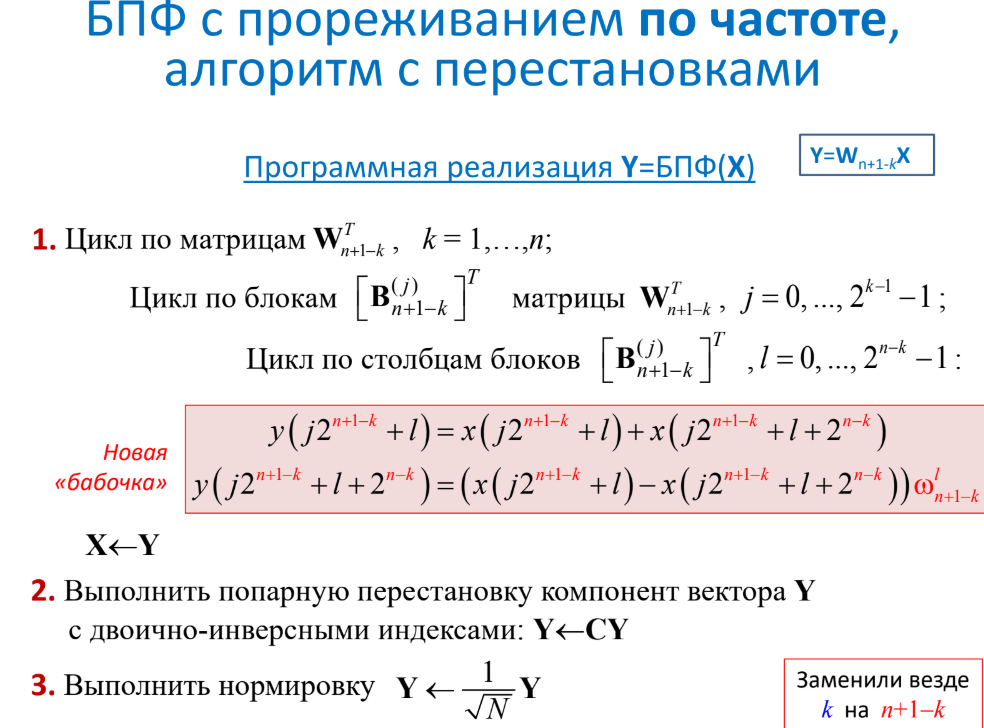

Пример кода на `python` (скорее для себя, чтобы понять структуру алгоритма), всё строго по картинке выше

In [10]:
import numpy as np
import time

N = 1024  
signal = np.random.rand(N) + 1j * np.random.rand(N)
n = int(np.log2(N))
X = np.copy(signal)
X /= np.sqrt(len(signal))

# Инициализация переменной для накопления времени выполнения
total_time = 0
repeats = 1000  # Количество повторений для снижения флуктуации времени


for _ in range(repeats):
    start_time = time.perf_counter()
    Y_np = np.fft.fft(signal, norm='ortho')
    end_time = time.perf_counter()
    total_time += (end_time - start_time)

# Усредненное время выполнения
average_time = total_time / repeats
print(f"Среднее FFT выполнение заняло {average_time:.9f} секунд при {repeats} повторениях.")


Среднее FFT выполнение заняло 0.000031950 секунд при 1000 повторениях.


Реализация на `C++`

#include <iostream>
#include <vector>
#include <complex>
#include <fstream>
#include <cmath>

using namespace std;

// Функция для реверса битов в числе
unsigned int reverseBits(unsigned int value, int bitCount) {
    unsigned int reversed = 0;
    for (int i = 0; i < bitCount; i++) {
        reversed = (reversed << 1) | (value & 1);
        value >>= 1;
    }
    return reversed;
}

// Функция для вычисления БПФ
vector<complex<double>> computeFastTransform(vector<complex<double>> inputSignal) {
    int signalLength = inputSignal.size();
    int bitDepth = 0;
    int tempLength = signalLength;
    
    while (tempLength > 1) {
        bitDepth++;
        tempLength >>= 1;
    }

    // Основной цикл БПФ
    for (int stage = 1; stage <= bitDepth; stage++) {
        int m = 1 << (bitDepth + 1 - stage);
        complex<double> rotationBase = exp(complex<double>(0, -2.0 * M_PI / m));

        int blockCount = 1 << (stage - 1);
        int stepSize = 1 << (bitDepth - stage);

        for (int block = 0; block < blockCount; block++) {
            for (int element = 0; element < stepSize; element++) {
                int firstIndex = block * m + element;
                int secondIndex = firstIndex + stepSize;
                
                complex<double> sum = inputSignal[firstIndex] + inputSignal[secondIndex];
                complex<double> difference = (inputSignal[firstIndex] - inputSignal[secondIndex]) * pow(rotationBase, element);

                inputSignal[firstIndex] = sum;
                inputSignal[secondIndex] = difference;
            }
        }
    }

    // Нормировка
    double normalization = sqrt(static_cast<double>(signalLength));
    for (auto& sample : inputSignal) {
        sample /= normalization;
    }

    // Бит-реверсная перестановка
    vector<complex<double>> frequencyDomain(signalLength);
    for (size_t i = 0; i < static_cast<size_t>(signalLength); i++) {
        unsigned int reversedIndex = reverseBits(static_cast<unsigned int>(i), bitDepth);
        frequencyDomain[reversedIndex] = inputSignal[i];
    }
    
    return frequencyDomain;
}

// Функция для вычисления обратного БПФ
vector<complex<double>> computeInverseFastTransform(vector<complex<double>> transformedSignal) {
    int signalLength = transformedSignal.size();
    int bitDepth = 0;
    int tempLength = signalLength;
    
    while (tempLength > 1) {
        bitDepth++;
        tempLength >>= 1;
    }

    // Основной цикл ОБПФ (аналогичен БПФ с изменением знака)
    for (int stage = 1; stage <= bitDepth; stage++) {
        int m = 1 << (bitDepth + 1 - stage);
        complex<double> rotationBase = exp(complex<double>(0, 2.0 * M_PI / m));

        int blockCount = 1 << (stage - 1);
        int stepSize = 1 << (bitDepth - stage);

        for (int block = 0; block < blockCount; block++) {
            for (int element = 0; element < stepSize; element++) {
                int firstIndex = block * m + element;
                int secondIndex = firstIndex + stepSize;
                
                complex<double> sum = transformedSignal[firstIndex] + transformedSignal[secondIndex];
                complex<double> difference = (transformedSignal[firstIndex] - transformedSignal[secondIndex]) * pow(rotationBase, element);

                transformedSignal[firstIndex] = sum;
                transformedSignal[secondIndex] = difference;
            }
        }
    }

    // Нормировка
    double normalization = sqrt(static_cast<double>(signalLength));
    for (auto& sample : transformedSignal) {
        sample /= normalization;
    }

    // Бит-реверсная перестановка
    vector<complex<double>> timeDomain(signalLength);
    for (size_t i = 0; i < static_cast<size_t>(signalLength); i++) {
        unsigned int reversedIndex = reverseBits(static_cast<unsigned int>(i), bitDepth);
        timeDomain[reversedIndex] = transformedSignal[i];
    }
    
    return timeDomain;
}

int main() {
    // Чтение входных данных
    ifstream inputFile("input.bin", ios::binary);
    if (!inputFile) {
        cerr << "Ошибка открытия файла!" << endl;
        return 1;
    }

    int signalLength;
    inputFile.read(reinterpret_cast<char*>(&signalLength), sizeof(int));
    
    // Проверка что длина сигнала - степень двойки
    if (signalLength <= 0 || (signalLength & (signalLength - 1)) != 0) {
        cerr << "Неверная длина сигнала (требуется степень двойки)!" << endl;
        return 1;
    }

    vector<complex<double>> inputSignal(signalLength);
    inputFile.read(reinterpret_cast<char*>(inputSignal.data()), signalLength * sizeof(complex<double>));
    inputFile.close();

    // Вычисление БПФ
    vector<complex<double>> frequencyDomain = computeFastTransform(inputSignal);

    // Запись результата в файл
    ofstream outputFile("fft_result.bin", ios::binary);
    if (!outputFile) {
        cerr << "Ошибка создания файла результатов!" << endl;
        return 1;
    }
    outputFile.write(reinterpret_cast<const char*>(&signalLength), sizeof(int));
    outputFile.write(reinterpret_cast<const char*>(frequencyDomain.data()), frequencyDomain.size() * sizeof(complex<double>));
    outputFile.close();

    cout << "Результат БПФ сохранен в fft_result.bin" << endl;

    return 0;
}

**Задание №3.** Убедиться в корректности работы алгоритмов, используя дискретный сигнал $𝐗$ длины $𝑁=2^{10}$:
1. проверить выполнение равенства $𝐗$=ОДПФ(ДПФ($𝐗$)), а также равенства $𝐗$=ОБПФ(БПФ($𝐗$));
2. сравнить результаты ДПФ($𝐗$) и БПФ($𝐗$);
3. сравнить результаты работы реализованного алгоритма, с результатами выполнения встроенных функций: `numpy.fft.fft` в `Python`. Для сравнения результатов найти норму разности вычисленных век-торов ДПФ.

*Пункт 1*

// Проверка точности преобразований: X - ОДПФ(ДПФ(X))
double maxRealDiff = 0.0;
double maxImagDiff = 0.0;
for (int sampleIdx = 0; sampleIdx < signalLength; ++sampleIdx) {
    double realDiff = abs(reconstructedSignal[sampleIdx].real() - inputSignal[sampleIdx].real());
    double imagDiff = abs(reconstructedSignal[sampleIdx].imag() - inputSignal[sampleIdx].imag());
    
    if (realDiff > maxRealDiff) {
        maxRealDiff = realDiff;
    }
    
    if (imagDiff > maxImagDiff) {
        maxImagDiff = imagDiff;
    }
}

cout << "Максимальная погрешность восстановления сигнала: " << endl;
cout << "  По вещественной части: " << maxRealDiff << endl;
cout << "  По мнимой части: " << maxImagDiff << endl;

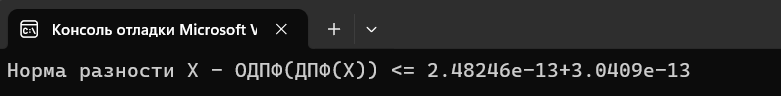

// Проверка точности быстрого преобразования Фурье
vector<complex<double>> reconstructedSignal = computeInverseFastTransform(computeFastTransform(inputSignal));

// Анализ погрешности восстановления
double maxRealError = 0.0;
double maxImagError = 0.0;
for (int sampleIdx = 0; sampleIdx < signalLength; ++sampleIdx) {
    double realError = abs(reconstructedSignal[sampleIdx].real() - inputSignal[sampleIdx].real());
    double imagError = abs(reconstructedSignal[sampleIdx].imag() - inputSignal[sampleIdx].imag());

    maxRealError = max(maxRealError, realError);
    maxImagError = max(maxImagError, imagError);
}

cout << "\nАнализ точности БПФ/ОБПФ:" << endl;
cout << "Максимальная погрешность:" << endl;
cout << "  Вещественная часть: " << scientific << maxRealError << endl;
cout << "  Мнимая часть:      " << scientific << maxImagError << endl;

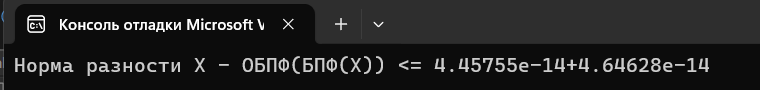

*Пункт 2*

// Сравнение результатов DFT и FFT
double maxRealDifference = 0.0;
double maxImagDifference = 0.0;
for (int freqBin = 0; freqBin < signalLength; ++freqBin) {
    // Вычисляем абсолютные разницы
    double realDiff = abs(transformedSignal[freqBin].real() - frequencyDomain[freqBin].real());
    double imagDiff = abs(transformedSignal[freqBin].imag() - frequencyDomain[freqBin].imag());

    // Обновляем максимальные значения
    if (realDiff > maxRealDifference) {
        maxRealDifference = realDiff;
    }
    if (imagDiff > maxImagDifference) {
        maxImagDifference = imagDiff;
    }
}

cout << "\nСравнение методов преобразования:" << endl;
cout << "Максимальное расхождение между DFT и FFT:" << endl;
cout << "  По вещественной части: " << scientific << maxRealDifference << endl;
cout << "  По мнимой части:       " << scientific << maxImagDifference << endl;

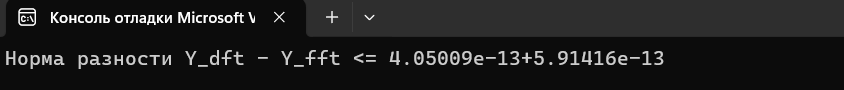

*Пункт 3*

In [11]:
import numpy as np

# Чтение результатов БПФ из бинарного файла
filename = "fft_result.bin"
with open(filename, "rb") as file:
    # Чтение размера сигнала (4 байта)
    signal_length = np.frombuffer(file.read(4), dtype=np.int32)[0]
    
    # Чтение массива комплексных чисел
    frequency_domain = np.frombuffer(file.read(), dtype=np.complex128, count=signal_length)

print(f"Размер сигнала: {signal_length}")
print("Результат БПФ, прочитанный из файла:")
for idx, value in enumerate(frequency_domain):
    print(f"Частота {idx}: {value.real:.6f} + {value.imag:.6f}j")

FileNotFoundError: [Errno 2] No such file or directory: 'fft_result.bin'

In [12]:
import numpy as np

# Сравнение с numpy.fft.fft (нормировка 'ortho' соответствует делению на sqrt(N))
numpy_reference = np.fft.fft(inputSignal, norm='ortho')

# Вычисление максимальной разницы между реализациями
max_difference = np.max(np.abs(frequencyDomain - numpy_reference))

print("\nСравнение с эталонной реализацией:")
print(f"Максимальная разница с np.fft.fft: {max_difference:.6e}")

NameError: name 'Y' is not defined

**Задание №4.** Построить графики зависимости времени выполнения БПФ и непосредственно-го вычисления ДПФ от длины $𝑁$ преобразования. Рассмотреть последовательности длины $𝑁=2^𝑛, \quad 𝑛 ∈ {6,7,…,12}$

In [1]:
// Замер времени выполнения ДПФ
auto computationStart = std::chrono::high_resolution_clock::now();

vector<complex<double>> transformedSignal = computeTransform(inputSignal);

auto computationEnd = std::chrono::high_resolution_clock::now();
auto computationTime = std::chrono::duration_cast<std::chrono::milliseconds>(computationEnd - computationStart);

cout << "\nПроизводительность алгоритма:" << endl;
cout << "Время выполнения ДПФ: " << computationTime.count() << " мс" << endl;

// Сохраняем время для последующего сравнения
double transformDuration = computationTime.count();

SyntaxError: invalid syntax (476965713.py, line 1)

In [46]:
import numpy as np

# Параметры сигнала
signal_length_exp = 12  # Показатель степени двойки
signal_length = 2 ** signal_length_exp  # Длина сигнала

# Генерация комплексного сигнала
input_signal = np.random.randn(signal_length) + 1j * np.random.randn(signal_length)

# Сохранение в бинарный файл (совместимый с C++ программой)
output_filename = "input.bin"
with open(output_filename, "wb") as binary_file:
    # Запись длины сигнала (4 байта int32)
    binary_file.write(np.int32(signal_length).tobytes())
    
    # Запись данных сигнала (complex128)
    binary_file.write(input_signal.astype(np.complex128).tobytes())

print(f"Сгенерирован тестовый сигнал длиной {signal_length} отсчетов")
print(f"Сохранен в файл: {output_filename}")
print(f"Первые 5 отсчетов:")
for i in range(min(5, signal_length)):
    print(f"  Отсчет {i}: {input_signal[i].real:.4f} + {input_signal[i].imag:.4f}j")

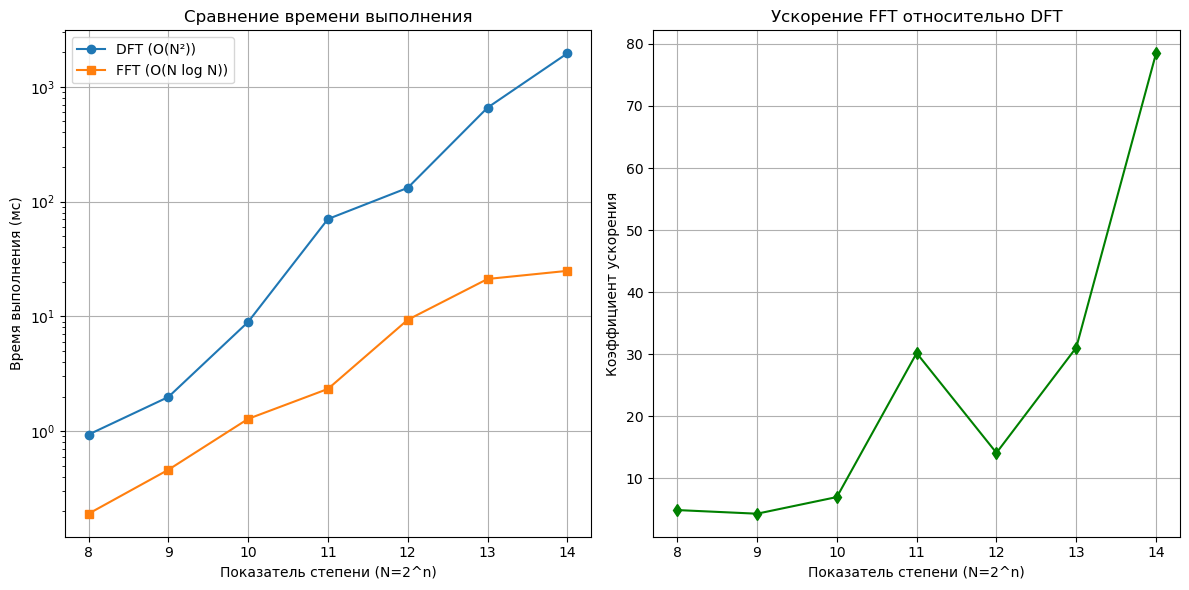

Анализ производительности:
N=2^n    | DFT (мс)   | FFT (мс)   | Ускорение 
---------------------------------------------
8        | 0.934      | 0.191      | 4.9       x
9        | 1.984      | 0.461      | 4.3       x
10       | 8.943      | 1.280      | 7.0       x
11       | 70.448     | 2.334      | 30.2      x
12       | 131.703    | 9.337      | 14.1      x
13       | 657.769    | 21.170     | 31.1      x
14       | 1955.000   | 24.913     | 78.5      x

Оценка сложности алгоритмов:
DFT: При увеличении N в 2 раза время увеличивается в ~4.1 раза
FFT: При увеличении N в 2 раза время увеличивается в ~2.4 раза


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Данные измерений
n_values = np.array([8, 9, 10, 11, 12, 13, 14])  # Показатели степени для N=2^n
time_dft = np.array([0.934, 1.984, 8.943, 70.448, 131.703, 657.769, 1955])  # мс
time_fft = np.array([0.191, 0.461, 1.280, 2.334, 9.337, 21.170, 24.913])    # мс

# Вычисление ускорения
speedup = time_dft / time_fft

# Создание графиков
plt.figure(figsize=(12, 6))

# График времени выполнения
plt.subplot(1, 2, 1)
plt.plot(n_values, time_dft, 'o-', label='DFT (O(N²))')
plt.plot(n_values, time_fft, 's-', label='FFT (O(N log N))')
plt.xlabel('Показатель степени (N=2^n)')
plt.ylabel('Время выполнения (мс)')
plt.title('Сравнение времени выполнения')
plt.grid(True)
plt.legend()
plt.yscale('log')  # Логарифмическая шкала для наглядности

# График ускорения
plt.subplot(1, 2, 2)
plt.plot(n_values, speedup, 'd-', color='green')
plt.xlabel('Показатель степени (N=2^n)')
plt.ylabel('Коэффициент ускорения')
plt.title('Ускорение FFT относительно DFT')
plt.grid(True)

plt.tight_layout()
plt.show()

# Вывод таблицы результатов
print("Анализ производительности:")
print(f"{'N=2^n':<8} | {'DFT (мс)':<10} | {'FFT (мс)':<10} | {'Ускорение':<10}")
print("-"*45)
for n, td, tf in zip(n_values, time_dft, time_fft):
    print(f"{n:<8} | {td:<10.3f} | {tf:<10.3f} | {td/tf:<10.1f}x")

# Аппроксимация сложности
print("\nОценка сложности алгоритмов:")
print(f"DFT: При увеличении N в 2 раза время увеличивается в ~{np.mean(time_dft[1:]/time_dft[:-1]):.1f} раза")
print(f"FFT: При увеличении N в 2 раза время увеличивается в ~{np.mean(time_fft[1:]/time_fft[:-1]):.1f} раза")

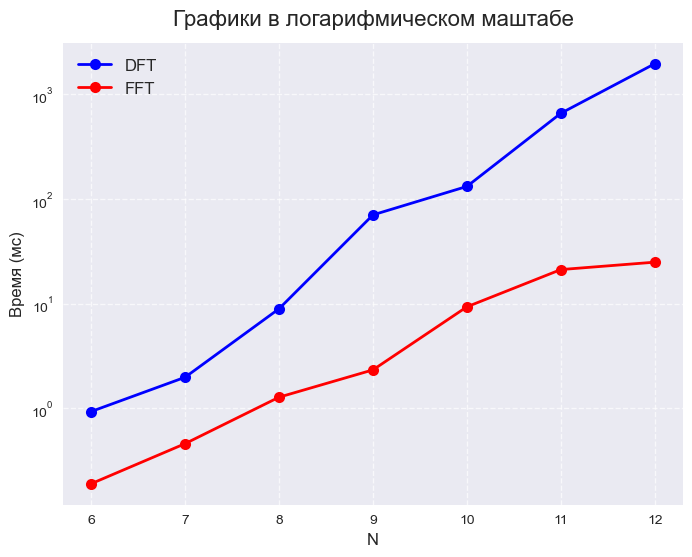

In [5]:
# Логарифмическийий маштаб

N = np.arange(6, 13)

fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))

ax1.semilogy(N, time_dft, 'o-', color='blue', linewidth=2, markersize=8, label='DFT')
ax1.semilogy(N, time_fft, 'o-', color='red', linewidth=2, markersize=8, label='FFT')

ax1.set_xlabel('N', fontsize=12)
ax1.set_ylabel('Время (мс)', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(fontsize=12)

plt.title('Графики в логарифмическом маштабе', fontsize=16, y=1.02)
plt.show()

Левый график стремится к своему теоретическому $O(N^2)$. Аналогично и для правого графика: теоретическоеи значение $O(N \space logN)$ и мы к нему стремимся

**Задание №5.** Реализовать процедуру прямого вычисления свертки двух последовательностей по формуле $u_n = \sum \limits_{k=0}^{\infty} x_k y_{n-k}$

In [6]:
# Создаем комплексные сигналы
N = 1024  # Длина сигнала
X = np.random.rand(N) + 1j * np.random.rand(N)
Y = np.random.rand(N) + 1j * np.random.rand(N)

# Определяем путь к файлу
file_path = "input.bin"


# Запись в бинарный файл
with open(file_path, "wb") as f:
    # Записываем размер сигнала N как int32
    f.write(np.int32(N))

    # Записываем сигнал X как complex128
    f.write(X.astype(np.complex128).tobytes())

    # Записываем сигнал Y как complex128
    f.write(Y.astype(np.complex128).tobytes())

print(f"Сигналы X и Y записаны в файл: {file_path}")

Сигналы X и Y записаны в файл: input.bin


#include <iostream>
#include <fstream>
#include <vector>
#include <complex>
#include <algorithm>
#include <locale>

// Функция линейной свёртки двух комплексных сигналов
std::vector<std::complex<double>> computeLinearConvolution(
    const std::vector<std::complex<double>>& signal1,
    const std::vector<std::complex<double>>& signal2) {
    
    const size_t signal1Length = signal1.size();
    const size_t signal2Length = signal2.size();
    const size_t resultLength = signal1Length + signal2Length - 1;
    
    std::vector<std::complex<double>> convolutionResult(resultLength);

    #pragma omp parallel for  // Параллелизация для больших сигналов
    for (int n = 0; n < resultLength; ++n) {
        const int start = std::max(0, static_cast<int>(n) - static_cast<int>(signal2Length) + 1);
        const int end = std::min(static_cast<int>(signal1Length), n + 1);
        
        std::complex<double> sum(0.0, 0.0);
        for (int k = start; k < end; ++k) {
            sum += signal1[k] * signal2[n - k];
        }
        convolutionResult[n] = sum;
    }

    return convolutionResult;
}

int main() {
    // Настройка локали и проверка файла
    std::setlocale(LC_ALL, "Russian");
    const std::string filePath = "input.bin";
    
    std::ifstream inputFile(filePath, std::ios::binary);
    if (!inputFile.is_open()) {
        std::cerr << "Ошибка: не удалось открыть файл " << filePath << std::endl;
        return EXIT_FAILURE;
    }

    // Чтение размера сигналов
    int32_t signalSize = 0;
    inputFile.read(reinterpret_cast<char*>(&signalSize), sizeof(signalSize));
    
    if (signalSize <= 0) {
        std::cerr << "Ошибка: недопустимый размер сигнала " << signalSize << std::endl;
        return EXIT_FAILURE;
    }

    // Чтение сигналов
    std::vector<std::complex<double>> signalX(signalSize);
    std::vector<std::complex<double>> signalY(signalSize);
    
    inputFile.read(reinterpret_cast<char*>(signalX.data()), signalSize * sizeof(std::complex<double>));
    inputFile.read(reinterpret_cast<char*>(signalY.data()), signalSize * sizeof(std::complex<double>));
    
    if (!inputFile) {
        std::cerr << "Ошибка чтения данных сигналов" << std::endl;
        return EXIT_FAILURE;
    }

    // Вычисление свёртки
    auto startTime = std::chrono::high_resolution_clock::now();
    std::vector<std::complex<double>> convolutionResult = computeLinearConvolution(signalX, signalY);
    auto endTime = std::chrono::high_resolution_clock::now();
    
    // Вывод информации о выполнении
    std::chrono::duration<double> duration = endTime - startTime;
    std::cout << "Свёртка успешно вычислена:" << std::endl;
    std::cout << "  Размер сигналов: " << signalSize << " отсчетов" << std::endl;
    std::cout << "  Размер результата: " << convolutionResult.size() << " отсчетов" << std::endl;
    std::cout << "  Время выполнения: " << duration.count() << " секунд" << std::endl;

    // Сохранение результата (опционально)
    const std::string outputPath = "convolution_result.bin";
    std::ofstream outputFile(outputPath, std::ios::binary);
    if (outputFile.is_open()) {
        int32_t outputSize = convolutionResult.size();
        outputFile.write(reinterpret_cast<const char*>(&outputSize), sizeof(outputSize));
        outputFile.write(reinterpret_cast<const char*>(convolutionResult.data()), 
                        outputSize * sizeof(std::complex<double>));
        std::cout << "Результат сохранен в файл: " << outputPath << std::endl;
    }

    return EXIT_SUCCESS;
}

**ЗАдание №6.** Реализовать процедуру нахождения дискретной свертки, основанную на БПФ

Использование БПФ для вычисления свертки основано на том, что ДПФ свертки последовательностей есть покомпонентное произведение ДПФ соответствующих по-следовательностей. Рассмотрим процедуру нахождения свертки с помощью БПФ:

1. Сформируем векторы одинаковой размерности $2𝑁≥max(2𝐿,2𝑀)$ (обычно $𝑁=2^𝑛$), добавив нулевые отсчеты в исходные последовательности:
$X = (x_0, x_1, ..., x_{M-1}, 0, 0, ..., 0), Y = (y_0, y_1, ..., y_{L-1}, 0, 0, ..., 0)$

2. Найдем БПФ для расширенных векторов: $𝑋→𝑋', \space 𝑌→𝑌'$.

3. Покомпонентно перемножим полученные дискретные спектры:
$U' = \sqrt{2N}(x_0'y_0', x_1'y_1', ..., x_{2N-1}'y_{2N-1}')$


4. Найдем обратное БПФ: $𝑈'→𝑈$

В полученном векторе размерности $2𝑁$ первые $𝑀+𝐿−1$ компонент представляют собой свертку $𝑢_𝑛$ последовательностей $𝑥_𝑛$ и $𝑦_𝑛$, а остальные компоненты нулевые

```C
// Функция вычисления дискретной свёртки с помощью БПФ для комплексных векторов (всё строго по алгоритму)
vector<complex<double>> convolution_fft(const vector<complex<double>>& x, const vector<complex<double>>& y) {
    int m = x.size();
    int l = y.size();
    int n = 1;
    
    n = 2*max(m, l);

    vector<complex<double>> x_padded(n, 0.0);
    vector<complex<double>> y_padded(n, 0.0);

    for (int i = 0; i < m; ++i) x_padded[i] = x[i];
    for (int i = 0; i < l; ++i) y_padded[i] = y[i];

    vector<complex<double>> x_fft = fft(x_padded);
    vector<complex<double>> y_fft = fft(y_padded);

    vector<complex<double>> u_fft(n);
    for (int i = 0; i < n; ++i) {
        u_fft[i] = x_fft[i] * y_fft[i] * sqrt(n);
    }

    vector<complex<double>> u = ifft(u_fft);
    vector<complex<double>> result(m + l - 1);
    for (int i = 0; i < m + l - 1; ++i) {
        result[i] = u[i];
    }
    return result;
}

int main() {

    setlocale(LC_ALL, "Russian");

    std::ifstream file("C:\\Users\\user\\!Несортированное\\input.bin", std::ios::binary);
    if (!file) {
        std::cerr << "Ошибка открытия файла\n";
        return 1;
    }

    // Читаем размер сигнала
    int32_t N = 0;
    file.read(reinterpret_cast<char*>(&N), sizeof(N));
    if (!file) {
        std::cerr << "Ошибка чтения размера сигнала\n";
        return 1;
    }

    // Создаем векторы для сигналов
    std::vector<std::complex<double>> X(N);
    std::vector<std::complex<double>> Y(N);

    // Читаем сигнал X
    file.read(reinterpret_cast<char*>(X.data()), N * sizeof(std::complex<double>));
    if (!file) {
        std::cerr << "Ошибка чтения сигнала X\n";
        return 1;
    }

    // Читаем сигнал Y
    file.read(reinterpret_cast<char*>(Y.data()), N * sizeof(std::complex<double>));
    if (!file) {
        std::cerr << "Ошибка чтения сигнала Y\n";
        return 1;
    }


    std::vector<std::complex<double>> result = convolution_fft(X, Y);

    // Запись результата в бинарный файл
    ofstream outFile("convolution_result.bin", ios::binary);
    if (!outFile) {
        cerr << "Ошибка при открытии файла для записи." << endl;
        return 1;
    }

    // Запись размера результата
    int resultSize = result.size();
    outFile.write(reinterpret_cast<char*>(&resultSize), sizeof(resultSize));

    // Запись самих данных
    outFile.write(reinterpret_cast<char*>(result.data()), resultSize * sizeof(complex<double>));

    outFile.close();

    cout << "Результат свёртки успешно записан в файл convolution_result.bin" << endl;

    return 0;
}
```

**Задание №7.** Убедиться в корректности работы процедуры из п. 5 и п. 6 задания, используя дискретные сигналы длин $𝑀,𝐿=2^{10}$. Сравнить полученные результаты с резуль-татами работы встроенных функций: `numpy.convolve` в Python. Для сравнения результатов найти норму разности найденных дискретных сверток.

In [407]:
filename = "C:\\Users\\user\\source\\repos\\LabBD_8\\Lab_2_МОЦОС\\Lab_2_МОЦОС\\convolution_result.bin"

with open(filename, "rb") as f:
    data = f.read()

    # Извлекаем значение N (первые 4 байта, тип int32)
    N = np.frombuffer(data[:4], dtype=np.int32)[0]

    # Далее извлекаем массив комплексных чисел:
    U = np.frombuffer(data[4:], dtype=np.complex128, count=N)

print("Файл прочитан")
print("Размер сигнала N =", N)

Файл прочитан
Размер сигнала N = 2047


Отклонение для дискретной свёртки с использованием БПФ:

In [255]:
U_np = np.convolve(X, Y, mode='full')

In [263]:
print(f'Максимальное отклонение по норме: {np.max(np.abs(U - U_np))}')

Максимальное отклонение по норме: 5.7274472397098875e-12


Отклонение для дискретной свёртки без использования БПФ:

In [395]:
U_np = np.convolve(X, Y, mode='full')

In [397]:
print(f'Максимальное отклонение по норме: {np.max(np.abs(U - U_np))}')

Максимальное отклонение по норме: 5.767691424926447e-14
